# Eric Osband Data Science Project: Glass-classification (glassification)
**NOTE: ** I discussed elements of this lab with Chris Ward.

# Table of Contents

<font size = "+1.5"><ul style="list-style-type:upper-roman">
    <li>[Import Statements](#import)</li>
    <li>[Load Data](#load)</li>
    <li>[Missing Data](#missing)</li>
    <li>[Visualizing Features](#visualizingFeatures)</li>
    <li>[General Preprocessing](#general)</li>
    <li>[Dimensionality Reduction](#dimensionalityReduction)</li>
    <li>[Feature Engineering](#feature)</li>
    <li>[Choosing Models](#choosing)</li>
    <li>[Test-Train Split](#test-train)</li>
    <li>[Validation to Determine Hyperparameters](#validation)</li>
    <li>[Fitting](#fitting)</li>
    <li>[Decision Trees and Random Forests](#trees)</li>
    <li>[Metrics](#metrics)</li>
    <li>[Visualizing Fits](#visualizingFits)</li>
    <li>[Analyzing RMSE](#analyzing)</li>
    <li>[Conclusion](#conclusion)</li>
</ul></font>

# Import Statements <a id = "import">

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # needed for 3d plotting
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import seaborn as sns
from statistics import mean
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


%matplotlib inline
#plt.style("")

# Load Data <a id = "load">

In [6]:
df = pd.read_csv("glass.csv")
df.head()
#for r in range(100):
#    s = 0
#    for c in range(1,df.shape[1]-1): # not including RI and Type
#        s += df.iloc[r,c]
#    print(s)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Source of the dataset: https://www.kaggle.com/uciml/glass

This dataset is a dataset of various samples of glass. This dataset has 215 valid samples. The target is the glass type - already converted into integers between 1 and 7 inclusive, and the features are the refractive index of the sample (RI), as well as the percent by weight of each of the following elements: Mg (Magnesium), Al (Aluminum), Si (Silicon), K (Potassium), Ca (Calcium), Ba (Barium), Fe (Iron). Thus this is a classification dataset, and each of the number classes of glass type corresponds to the use of the glass type as follows:

1 – float-processed building windows  
2 – non-float-processed building windows  
3 – float-processed vehicle windows  
4 – non-float-processed vehicle windows  
5 – containers  
6 – tableware  
7 – headlamps  

This may not seem like the most interesting dataset, but most of the other ones I found have had 20-40 features in them, and since the goal in this project is to create a rigorous model on just a few features, I felt I could not justify simply dropping most of the features in those other datasets to make it the way I liked. This dataset is also very useful with our current knowledge since each of the features is numerical or ordinal – rather than categorical – and just in thinking about each of the features, I can envision myself manipulating certain features to have more of an impact or less of an impact on the target. For example, I know silicone is one of the main elements in glass, so I expect to make some additional features out of it. In other datasets, since I don't really know and understand what each of the features mean, I wouldn't know where to start. I also especially like how the target has a couple different classes, rather than just 2 as we usually see. I think this dataset will be both rigorous and feasible to analyze and fit, and I personally have never thought much about different types of glass before, so this will be a good place to start and learn some information!

In [7]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Since all of these columns appear to have correct values, as in the minimum value is realistic for the unit of measurement, I do not have to drop any columns nor do I have to remove any incorrect values. All I will have to do is deal with any possible completely-missing data. 

In [8]:
target = "Type"
cols = list(df.columns)
cols.remove(target)
colsOld = cols
print("Number of features: " + str(len(cols))) # Number of features
print("Number of target classes: " + str(len(df[target].unique())))
print("Target classes: " + str(df[target].unique()))

Number of features: 9
Number of target classes: 6
Target classes: [1 2 3 5 6 7]


Now cols will contain the names of all the features in the dataset. Above is written the number of features and the number of target classes. Note that even though there are 6 target classes, the classes are numbered 1-7, with no class 4. I could change all the 6s to 5s and 7s to 6s to make this continuous, but I think it is more accurate to leave the classes as they are since that is how the dataset originated.

# Missing Data <a id = "missing">

In [9]:
print(df.isnull().values.any()) # Checks if there are any null or NaN values in the dataset

False


Since there are no null of NaN values in my dataset, I do not need to remove any. Thus my dataset is now fully cleaned and ready for analysis. 

# Visualizing Features <a id = "visualizingFeatures">

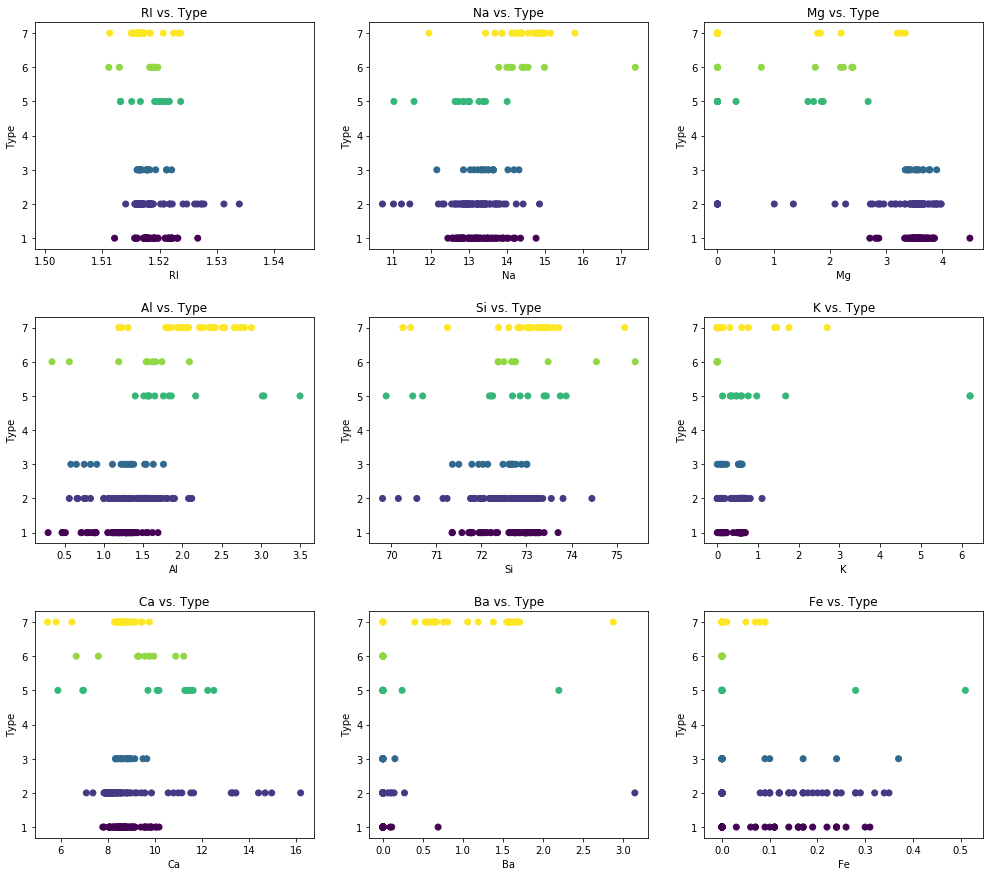

In [10]:
# colors = ['violet','blue','cyan','green','yellow','orange','red']
# def color_chooser(x): # standard color choosing function, I defined the colors i want to choose from above
#     return colors[x-1]

i = 0
nRows = math.ceil(len(cols) / 3)
nCols = 3
f = plt.figure(figsize=(17,15))

for col in cols:
    i += 1
    ax = f.add_subplot(nRows * 100 + nCols * 10 + i)
    ax.scatter(df[col],df[target], c = df[target]) #np.vectorize(color_chooser)(df[target]))
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(str(col) + " vs. Type")

#plt.tight_layout() # Makes the graphs not overlap. I found this from https://matplotlib.org/users/tight_layout_guide.html
f.subplots_adjust(wspace = 0.2, hspace=0.3) # gives the graphs extra spacing. I found this from https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
plt.show()

At first glance, I notice that Ba, Fe, Al, Ca, and Mg seem to be the features that separate the glass type the best. Still, they are not perfect, and so I will do continue with my analysis, specifically feature engineering, to try and flesh them out. For example, since Ba goes from 0 to 3 on the x axis, I will square or cube the column so that the data spreads out. I will also increase the power on other features to similarly spread out the data. 

# General Preprocessing <a id = "general">

None needed in this case since the data is already processed!

# Dimensionality Reduction <a id = "dimensionalityReduction">

In [11]:
cols.remove("RI")
cols.remove("K")
print(cols)

['Na', 'Mg', 'Al', 'Si', 'Ca', 'Ba', 'Fe']


Just after looking at it at first glance, I see that RI and K have almost no effect on the class of the glass. The others don't have that much visible effect themselves, but I think it is fair to say that RI has the least variance. Thus I am dropping them. All I need to do to drop it is remove it from the list "cols", since that is how I am accessing columns after this. 

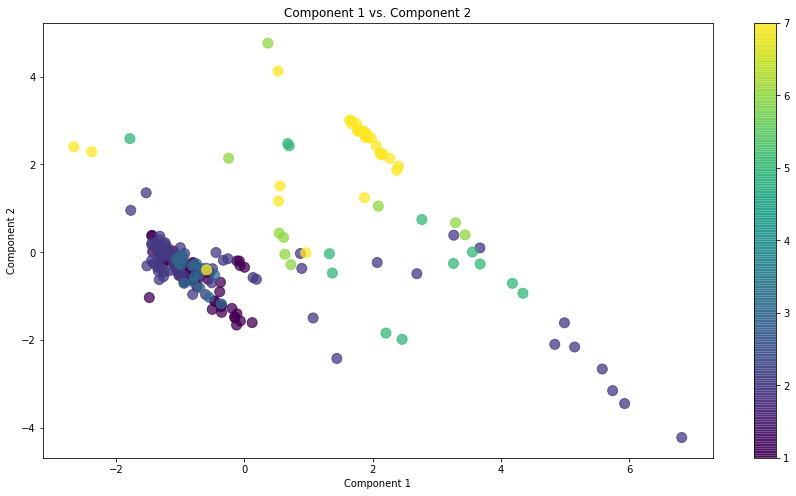

In [12]:
# PCAs
pca = PCA(n_components = 2)
x_pca = pca.fit(df[cols]).transform(df[cols])
plt.figure(figsize = (15,8))
plt.scatter(x_pca[:,0],x_pca[:,1], s = 100,c = df[target], alpha = 0.75, marker = "o",)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Component 1 vs. Component 2")
plt.colorbar()
plt.show()

# Now x_pca is a two-dimensional list of the two axes along the data with the most variance

This graph is of the two axes with highest variance in the data, labeled Component 1 and Component 2, with a colorbar to help identify classes. As you can see, the data does not separate well, especially between classes 1, 2, and 3. Even outside of just those classes, there is a lot of overlap in the datapoints. I will continue on to analyze these two components later, for example with a decision trees and random forests.

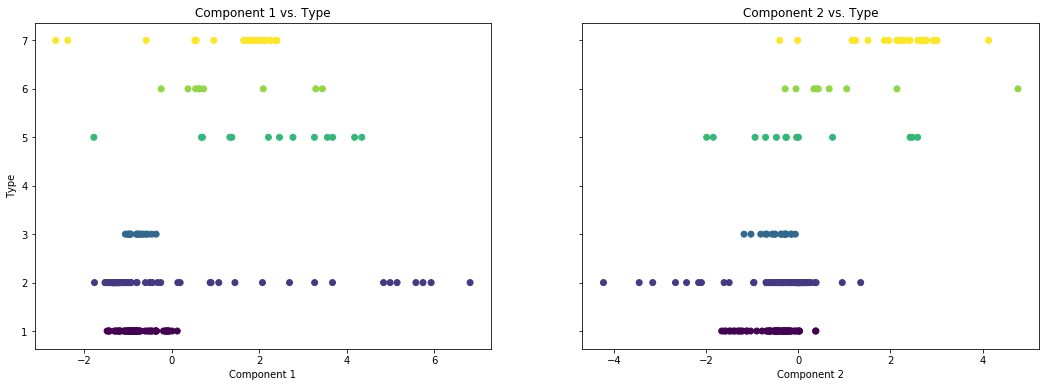

In [13]:
f, (ax1, ax2) = plt.subplots(1,2,sharey = True, figsize = (18,6))
ax1.set_ylabel("Type")
ax1.scatter(x_pca[:,0],df[target], c = df[target])
ax1.set_title("Component 1 vs. Type")
ax1.set_xlabel("Component 1")
ax2.scatter(x_pca[:,1],df[target], c = df[target])
ax2.set_title("Component 2 vs. Type")
ax2.set_xlabel("Component 2")
plt.show()

This is another way to visualize the two components: plotting each of them against the target. Clearly though, neither is that great as the data once again does not separate cleanly.

**NOTE: ** These two axes, however, are based on the unengineered features. PCA will need to be re-run later on based on the data with the engineered features.

# Feature Engineering <a id = "feature">

In [14]:
colsChanging = ['Ba','Fe'] # columns I want to engineer
n = 4 # max power
for j in range(2,n+1):
    for col in colsChanging:
        newCol = col + "^" + str(j)
        df[newCol] = df[col] ** j
        cols.append(newCol) # now cols has been updated to contain the engineered column as well
df[cols].head()

,Na,Mg,Al,Si,Ca,Ba,Fe,Ba^2,Fe^2,Ba^3,Fe^3,Ba^4,Fe^4
0,13.64,4.49,1.10,71.78,8.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.89,3.60,1.36,72.73,7.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.53,3.55,1.54,72.99,7.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.21,3.69,1.29,72.61,8.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.27,3.62,1.24,73.08,8.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Choosing Models <a id = "choosing">

In [15]:
model = LogisticRegression()

This is pretty straightforward since this is a classification problem (so logistic regression), not numerical (linear) regression. However, the above cell is essentially useless since we will be determining the hyperparamters further on, so we will redesignate model to be a LogisticRegression model with that proper C. This line is only to demonstrate to you that I know this is logistic regression.

# Test-Train Split <a id = "test-train">

In [16]:
trainDF, testDF = train_test_split(df, test_size=0.25)
print(trainDF.shape)
print(testDF.shape)

(160, 16)
(54, 16)


The above split the datfame into two dataframes (test and train). It put 75% of the samples into the training dataframe and the remaining 25% into the test dataframe. I think 75-25 is a very reasonable and fairly standard split.

**NOTE: ** I did not need to do this split before PCAs because I am not using the PCAs to predict the target, I am simply using them to determine the axes of the data with the highest variance and visualize them

# Validation to Determine Hyperparameters <a id = "validation">

In [17]:
trainVDF, validationDF = train_test_split(trainDF, test_size=0.25)

Once again I split the dataframe (although this time I just split the training dataframe) into validation training (trainVDF) and validation testing (validationDF) dataframes.

In [18]:
modelV = LogisticRegression().fit(trainVDF[cols],trainVDF[target]) # the validation model
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = validationDF[target], y_pred = modelV.predict(validationDF[cols])))
print("Initial rmse: " + str(rmse)) # the RMSE of the default model (C = 1)

minC, maxC = 0.0000001, 100000000 # starting and stopping bounds for C
C = minC

RMSEs = [] # create a list of the RMSE of the model at each C

while C <= maxC:
    modelV = LogisticRegression(C = C).fit(trainVDF[cols],trainVDF[target]) # the validation model
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = validationDF[target], y_pred = modelV.predict(validationDF[cols])))
    RMSEs.append(rmse)
    C *= 10 # Since we really only care about the order of maginitude of the C that minimizes RMSE, not its definite value,
            # I am only cycling through the powers of C

m = min(RMSEs) 
print('Minimum RMSE: ' + str(m))
Cminimized = minC * (10**RMSEs.index(m)) # finds the C that corresponds to the minimized RMSE
print("This minimum occurs at C = " + str(Cminimized))


Initial rmse: 1.0
Minimum RMSE: 0.7416198487095663
This minimum occurs at C = 10.0


In this block I tested a bunch of different values for C (which is just 1/lambda), the hyperparameter in logistic regression models. I trained each model on the trainVDF dataframe (the dataframe to train the hyperparameter), and calculated the RMSE based on the validation dataframe. I then chose the minimum of all the RMSE's and found it's C value.

In [19]:
C = Cminimized

Now C stores the C that minimizes RMSE on the training dataframe.

# Fitting <a id = "fitting">

In [20]:
model = LogisticRegression(C = C)
model.fit(trainDF[cols],trainDF[target])
rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = model.predict(testDF[cols])))
print("RMSE of all features: " + str(rmse))

RMSE of all features: 1.4529663145135578


The above is fairly straightforward, simply fitting a logistic regression model at the proper C value and displaying its RMSE. 

# Decision Trees and Random Forests <a id = "trees">

For the decision trees and random forests, since I have so many features, plotting each pair of features individually would take up a huge amount of time and space, and is mostly useless or repeated data. Instead, I will plot the first two principal components from the unengineered features and from the engineered features. However, I will still compute the RMSEs of the models on entire engineered dataframe.

In [21]:
# Redoing the PCAs for the engineered dataset
pca = PCA(n_components = 2)
xE_pca = pca.fit(df[cols]).transform(df[cols]) # xE_pca is now a two-dimensional list containing the two axes of
                                               # highest variance with the engineered features

Standard PCA code. Note that, like before, I am running PCAs on the entire dataset rather than just the training set, which I can do since I'm not using the PCAs for prediction yet. 

In [22]:
# Source of this function: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
# Note: I made my own edits to the function to make it work for my own data
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    try:
        ax.scatter(X.iloc[:,0],X.iloc[:,1], c=y, s=30,
                   clim=(y.min(), y.max()), zorder=3)
    except:
        ax.scatter(X[:,0],X[:,1], c=y, s=30,
                    clim=(y.min(), y.max()), zorder=3)

    ax.axis('tight')
    ax.axis('on')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim) 
    names = list(X)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])

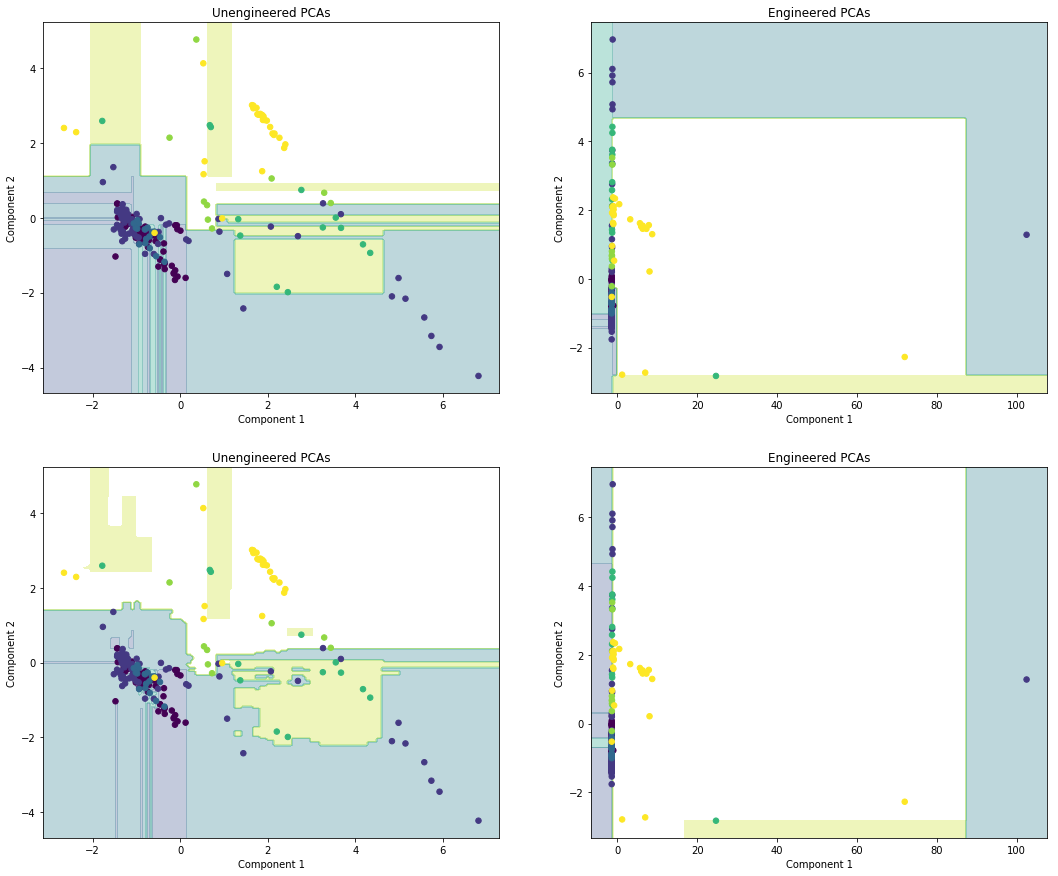

In [25]:
f, axes = plt.subplots(nrows = 2, ncols=2, figsize = (18,15)) 
tree = DecisionTreeClassifier()
tree.fit(x_pca,df[target]) # I am using the whole df[target] column (rather than the trainDF[target] columns)
                           # since the pca's were determined from the whole dataframe
treeE = DecisionTreeClassifier()
treeE.fit(xE_pca,df[target]) 


# Unengineered Tree
visualize_classifier(tree, x_pca, df[target], ax = axes[0][0])
axes[0][0].set_title("Unengineered PCAs")
axes[0][0].set_xlabel("Component 1")
axes[0][0].set_ylabel("Component 2")

# Engineered Tree
visualize_classifier(treeE, xE_pca, df[target], ax = axes[0][1])
axes[0][1].set_title("Engineered PCAs")
axes[0][1].set_xlabel("Component 1")
axes[0][1].set_ylabel("Component 2")

# Unengineered Forest
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(x_pca, df[target])
visualize_classifier(bag, x_pca, df[target], ax = axes[1][0])
axes[1][0].set_title("Unengineered PCAs")
axes[1][0].set_xlabel("Component 1")
axes[1][0].set_ylabel("Component 2")

# Engineered Forest
bagE = BaggingClassifier(treeE, n_estimators=100, max_samples=0.8)
bagE.fit(xE_pca, df[target])
visualize_classifier(bag, xE_pca, df[target], ax = axes[1][1])
axes[1][1].set_title("Engineered PCAs")
axes[1][1].set_xlabel("Component 1")
axes[1][1].set_ylabel("Component 2")


plt.show()


This is a visualization of the decision tree and random forest models on both sets of PCA data. I realize that there is a huge amount of whitespace on these graphs, and there shouldn't be, but I have tested this algorithm manny times on cleaner data and it works. For some reason, these datasets are too complicated for the graphing function to handle. Stil however, the gist is there, since the function correctly (or rather, as correctly as it can) colors the places where many classes intersect, and leaves the places where the points are mostly one color as white, so the viewer can interpret them easily. 

Also, I understand that in the engineered features, there are two outlying datapoints that sort of mess up the image and make the rest of the datapoints appear very close to 0. For the sake of visualizing, I will plot all the points except those below.

Initially, I did not feel comfortable simply removing them from the dataset since I only have 214 samples to begin with, and 60 of those are test data. However, after completing all of the analysis, I realized that the outliers really screwed up the logistic regression fits. Thus I came back and decided to remove those points (which I do a few cells below).

Cutoff boundary: 20


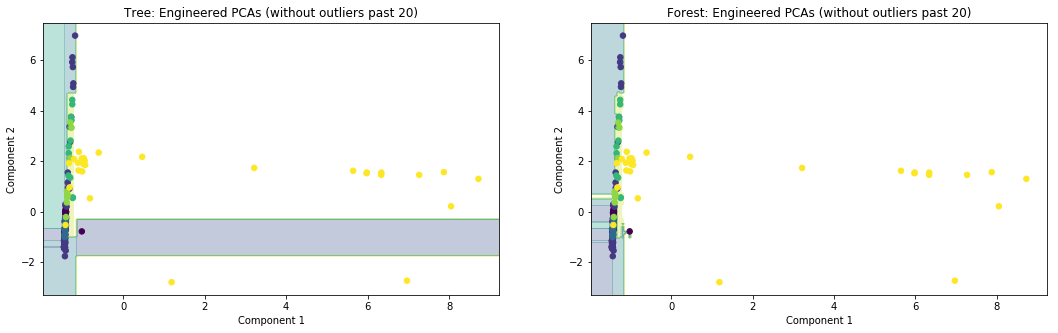

Cutoff boundary: 2


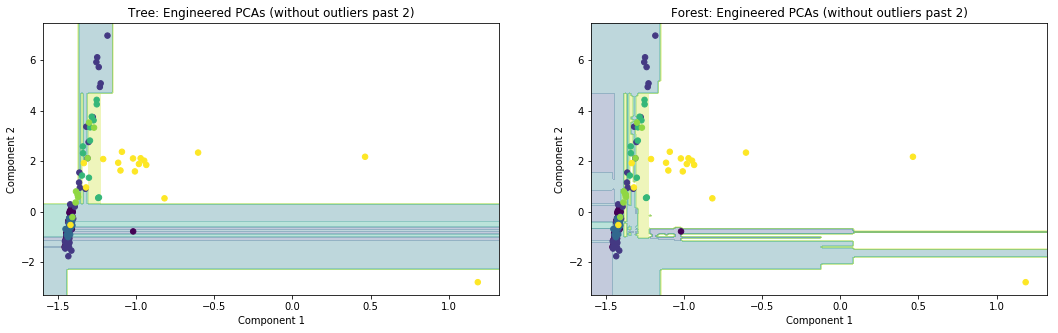

Cutoff boundary: -1


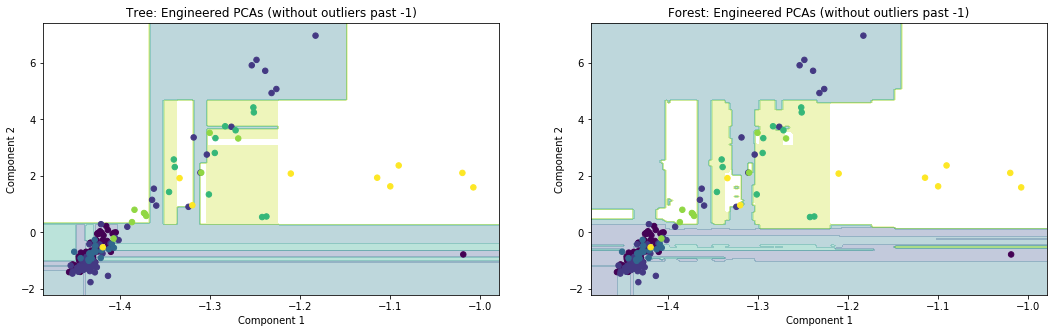

In [20]:
cutoffs = [20,2,-1] # I choose these cutoff value from the graph
for cutoff in cutoffs:
    
    f, axes = plt.subplots(nrows = 1, ncols=2, figsize = (18,5)) 

    xE_pca_NEW = []
    correctness = [] # correctness will be a boolean array so that I can boolean slice the target column of the dataframe
    for i in range(len(xE_pca[:,0])): # the outliers lie only along the axis of component 1
        elem = xE_pca[i,0]
        other = xE_pca[i,1]
        if elem < cutoff: # cycles through each cutoff value individually
            xE_pca_NEW.append([elem, other])
            correctness.append(True)
        else:
            correctness.append(False)

    xE_pca_NEW = np.array(xE_pca_NEW)

    treeE = DecisionTreeClassifier()
    treeE.fit(xE_pca_NEW,df[correctness][target]) 

    # Engineered Tree
    visualize_classifier(treeE, xE_pca_NEW, df[correctness][target], ax = axes[0])
    axes[0].set_title("Tree: Engineered PCAs (without outliers past " + str(cutoff) + ")")
    axes[0].set_xlabel("Component 1")
    axes[0].set_ylabel("Component 2")

    # Engineered Forest
    bagE = BaggingClassifier(treeE, n_estimators=100, max_samples=0.8)
    bagE.fit(xE_pca, df[target])
    visualize_classifier(bag, xE_pca_NEW, df[correctness][target], ax = axes[1])
    axes[1].set_title("Forest: Engineered PCAs (without outliers past " + str(cutoff) + ")")
    axes[1].set_xlabel("Component 1")
    axes[1].set_ylabel("Component 2")

    print("Cutoff boundary: " + str(cutoff))
    plt.show()

Clearly, the data looks a lot more pleasing and separable after removing these outliers, in turn making the decision trees and random forests look much more pleasing. Thus I will be removing those three datapoints (the ones outside 20) for the rest of the analysis, so that all the graphs look better.

In terms of these two models, the forest model clearly seems to be more accurate than the single tree, which makes sense sinec the forest is just an average over a bunch of trees. The forest model is also much more defined and less rigid than the tree, which once again makes sense. 

In [21]:
pca = PCA(n_components = 2)
xE_pca = pca.fit(trainDF[cols]).transform(trainDF[cols]) # only want to remove the outliers in the training data
xE_pca_NEW = []
correctness = []
for i in range(len(xE_pca[:,0])): 
    elem = xE_pca[i,0]
    if elem < 20:
        correctness.append(True)
    else:
        correctness.append(False)
trainDF = trainDF[correctness] # horizontally slice data

In [22]:
# Computing RMSEs of both models on entire training dataset (i.e. with outliers)
tree = DecisionTreeClassifier()
tree.fit(trainDF[cols],trainDF[target])
# Bag is the random forest classifier
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
                                        # These parameters were what the author of the above cited notebook
                                        # used in his function. I took them, learned what each meant, and
                                        # intentionally am choosing to reuse those same values. 
bag.fit(trainDF[cols],trainDF[target])
treePred = tree.predict(testDF[cols]) # now is an array containing the predictions of the tree on the test data
bagPred = bag.predict(testDF[cols]) # array of predictions of the random forest on the test data
rmseTree = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = treePred))
rmseBag = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = bagPred))
print("Decision tree RMSE: " + str(rmseTree))
print("Random forest (bag) RMSE: " + str(rmseBag))

Decision tree RMSE: 1.7213259316477407
Random forest (bag) RMSE: 1.130388330520878


As seen above, I computed the root mean square errors for both the decision tree classifier as well as the random forest (bagging) classifier, and I will later compare them to the root mean squared error of the traditional logistic regression model.

# Metrics <a id = "metrics">

In [23]:
combos = []
for i in range(1,len(cols)):
    combos.append(list(combinations(cols, i)))
# Combos is now a list containing all possible combinations of the features of the dataframe
    

a = [] 
for i in range(len(combos)):
    for j in range(len(combos[i])):
        a.append(list(combos[i][j]))
        
# a is just a flattened (1-D) array of the combos 
        
r = [] # will be an array of the training RMSEs of the different combinations
rTest = [] # will be array of the test RMSEs of the different combinations
index = -1 # will be index of the minimum train RMSE
indexTest = -1 # will be index of the minimum test RMSE

# First determine the lowest root mean squared error of the combinations on test data
for i in range(len(a)):
    elem = a[i] # elem is now a list of the current combination
    model = LogisticRegression(C = C)
    model.fit(trainDF[elem],trainDF[target])
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = model.predict(testDF[elem])))
    rTest.append(rmse)
    if index > -1:
        if rmse < rTest[indexTest]:
            indexTest = i
    else:
        indexTest = 0

# Second determine the lowest root mean squared error of the combinations on training data
for i in range(len(a)):
    elem = a[i] # elem is now a list of the current combination
    model = LogisticRegression(C = C)
    model.fit(trainDF[elem],trainDF[target])
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true = trainDF[target], y_pred = model.predict(trainDF[elem])))
    r.append(rmse)
    if index > -1:
        if rmse < r[index]:
            index = i
    else:
        index = 0


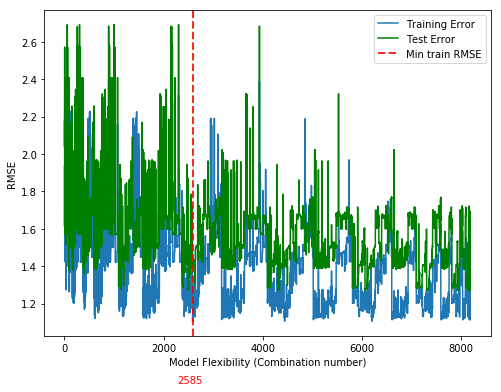

Total number of combinations: 8190
The best combination is: ['Na', 'Mg', 'Ca', 'Ba', 'Fe', 'Ba^3']
	In other words, all of the columns except the following: ['Al', 'Si', 'Ba^2', 'Fe^2', 'Fe^3', 'Ba^4', 'Fe^4']
Its minimized RMSE is 1.1052235010810132 at index 2585 (of the training model's RMSEs)


In [24]:
# basic plotting
indices = list(range(len(a)))
fig = plt.figure(figsize=(8,6))
plt.plot(indices, r, label="Training Error")
plt.plot(indices, rTest, c='g', label="Test Error")
plt.xlabel("Model Flexibility (Combination number)")
plt.ylabel("RMSE")
plt.axvline(index, c='r', linestyle = '--', linewidth = 2,alpha = 0.85, label = "Min train RMSE")
plt.legend(loc='upper right')
plt.text(index - 300, plt.ylim()[0]-0.25, str(index), color = 'r')
plt.show()

colsLeft = cols.copy()
for c in a[index]:
    colsLeft.remove(c)

print("Total number of combinations: " + str(len(a)))
print("The best combination is: " + str(a[index]))
print("\tIn other words, all of the columns except the following: " + str(colsLeft))
print("Its minimized RMSE is " + str(r[index]) + " at index " + str(index) + " (of the training model's RMSEs)")


The above graph is a graph of the training and test RMSE for each of the combinations. However since the combinations change in length and are not in a good order, the graph is not "nice" or very pleasing to look at. It doesn't have a good elbow, either. However the math all turns out the same, and  you can see above the best combination of features (i.e. the combination that achieves the lowest RMSE), the lowest RMSE, and the index (for visually locating on the graph) that value.

Note that the best combination contains none of the engineered features (in this case; when you run it you may not have the same), so my feature engineering did not do much.

# Visualizing Fits <a id = "visualizingFits">

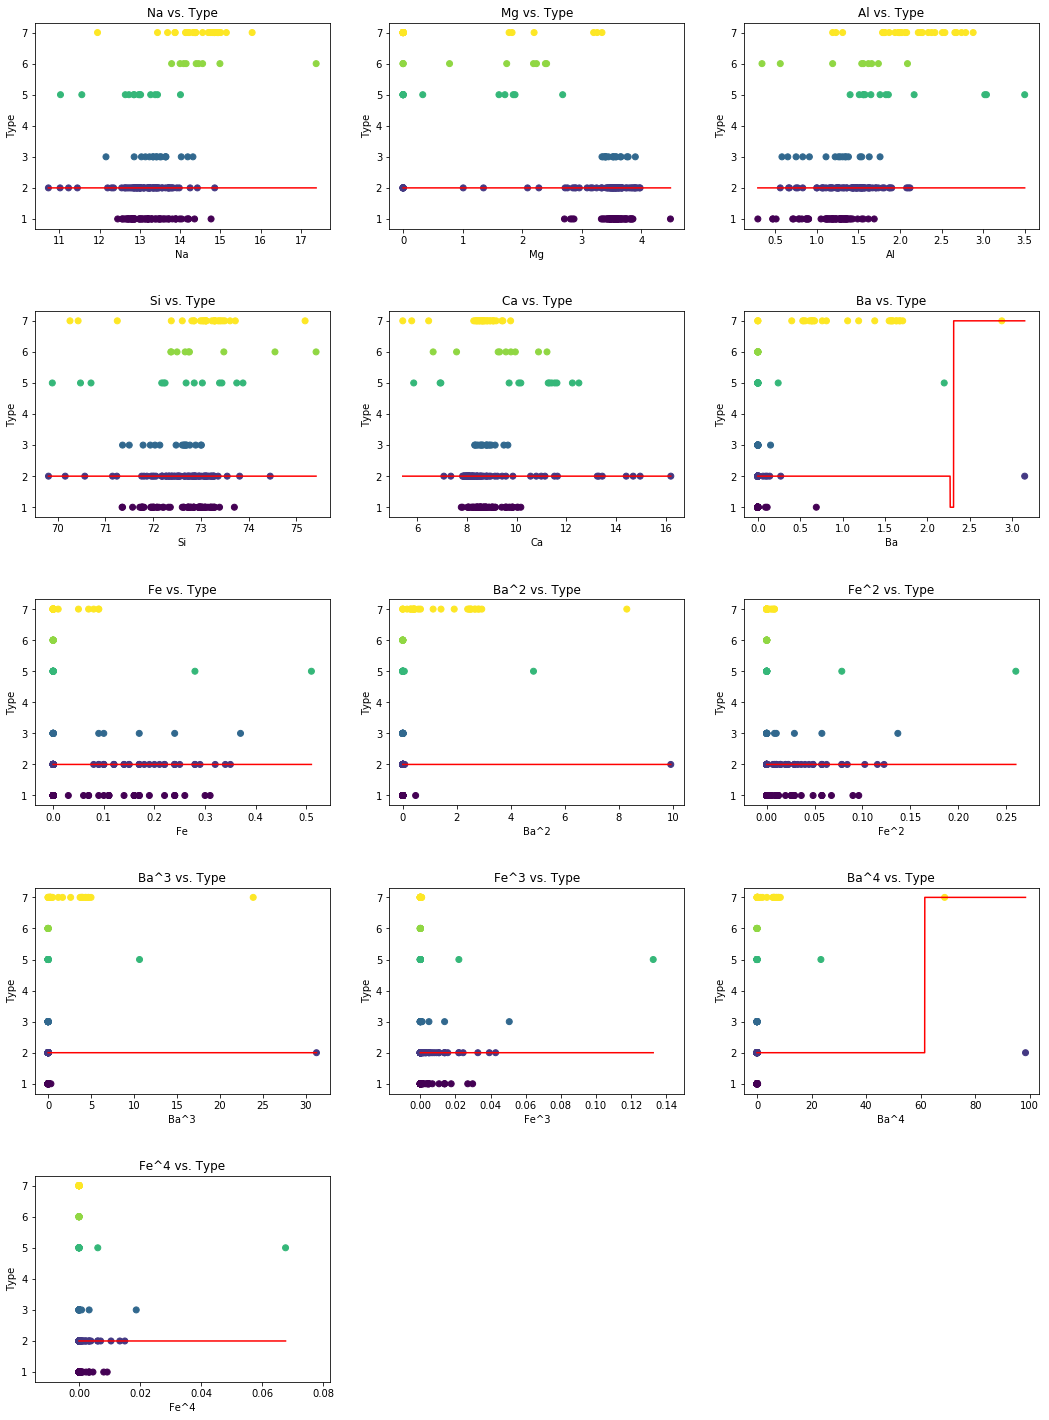

In [25]:
## Plotting the best model along the axes of each of the features
model = LogisticRegression(C = C)
model.fit(trainDF[cols],trainDF[target])
rmseLogistic = math.sqrt(sklearn.metrics.mean_squared_error(y_true = testDF[target], y_pred = model.predict(testDF[cols])))
density = 10000 # How smooth I want my curves to be (vs. how much time it takes to plot).
                # This was determined by trial and error
medians = [] # medians will be an array of the median value of each column
for i in range(len(cols)):
    medians.append(trainDF.iloc[:,i].median())

i = 0
nRows = math.ceil(len(cols) / 3)
nCols = 3 # making three columns of subplots
f = plt.figure(figsize=(18,25))
for col in colsOld: # colsOld is a list of the un-engineered features
    i += 1 # i is the plot number
    ax = f.add_subplot(nRows, nCols, i) # standard adding of a subplot
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(str(col) + " vs. Type")
    ax.scatter(df[col],df[target], c = df[target]) # scatter the datapoints
    xmin, xmax = df[col].min(), df[col].max() # plotting all points, not just the training data
    x = np.arange(xmin,xmax, (xmax-xmin)/density) # creating a range of x's
    d = {cols[k]: [medians[k]] * len(x) for k in range(len(cols))} # d is now a dictionary continaing all the medians
                                                                   # of each column

    d[col] = x
    j = 2
    s = str(col) + "^" + str(j)
    # Setting the columns we're plotting (i.e. the axis) to its proper values:
    while (s) in cols: # checking to see if this column has been engineered
        d[s] = x ** j # accounting for feature engineering
        j += 1
        s = str(col) + "^" + str(j)
    plottingDF = pd.DataFrame(d) # making a data frame out of d
    
    y = model.predict(plottingDF) # y is now a prediction based on the medians on all the features except the one we're plotting
    ax.plot(x,y, c = 'r')

#plt.tight_layout() # Makes the graphs not overlap. I found this from https://matplotlib.org/users/tight_layout_guide.html
f.subplots_adjust(wspace = 0.2, hspace=0.4) # gives the graphs extra spacing. I found this from https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
plt.show()



Clearly this fit is not perfect. There are many instances where the fit function chose to have a horizontal line as its best fit, which honestly makes sense given that the data was so hard to separate. In some other plots though, like Ba, the prediction is not only one value, but even then it does not outuput each of the classes, only 1 or 7 (or so it appears). This model does not look amazing, but it may just be because the built in logistic regression function is not the best model. That is why we will analyze the RMSEs of all the models below.

What I wrote above was accurate after one set of models. After rerunning these models a few times, however, the fit is now a horizontal line for each feature. This is objectively a terrible fit, but it makes sense when considering that class 2 likely has the most samples, so the LogisticRegression model decided to cut its losses and only predict class 2. I think that in order to make this model not do that, I would need more points (or rather, a more equal distribution of classes), or perhaps a more rigorous algorithm to remove outliers from each feature. If I tried to do that in this case, I would be left with very few samples and my model would likely be even less accurate. 

# Analyzing RMSE <a id = "analyzing">

In [26]:
print("Decision tree RMSE: " + str(rmseTree))
print("Random forest (bag) RMSE: " + str(rmseBag))
print("Logistic Regression RMSE: " + str(rmseLogistic))
print("\tUsing only the best combination of features: " + str(r[index]))

Decision tree RMSE: 1.7213259316477407
Random forest (bag) RMSE: 1.130388330520878
Logistic Regression RMSE: 1.3052600138300812
	Using only the best combination of features: 1.1052235010810132


Clearly, the decision tree's RMSE is the worst – thus making it the worst model out of the above – and the logistic regression's RMSE is the best, although in this case (which may not be the same for you) the RMSE is slightly worse with only the best combination of features.

# Conclusion <a id = "conclusion">

After all of this analysis, I still do not have a very accurate model for predicting the glass class type. I do have some knowledge about which elements help predict the type more than others – Barium, for example – but even then the model did not seem to pick up on that. The ultimate takeaway is that glass type is not extremely correlated to the percent masses of these elements, or rather that the models I have at my disposal, combined with my knowledge of data engineering, is not enough to create one extremely accurate model. 

There were a few problems along the way in this analysis, for example the whitespace on the decision tree and random forest model visualizations, but I have definitely taken many looks and tried to fix them. Yet I was not able to fix them. If I had infinite time at my disposal, or more processing power, I would likely create many new columns of features and mix them in, and maybe even retry this entire process with linear regression as well. I would see how those turned out, and take that information to make a better model that combines elements of all of the individual things I am doing. 

I do not have all that that, but I still learned many things about this dataset and this process, and believe this was a successful analysis.